In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  9 08:17:57 2023

@author: Joao

This script reads a training CSV, outputs predictions for the data, and applies
the score metric to compute the final score. 

It also computes a few other known metrics, like top-k accuracy and average power loss.


"""

# 'F5' Começa a debuger o codigo 
# 'F10' Analisar a linha sem entrar no codigo 
# 'F11' Analisar linha  e entrar no codigo 
# 'SHIFT-F11' sair do bloco de codigo atual e continuar a execução


import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

X_SIZE = 5      # 5 input samples
N_GPS = 2       # 2 GPSs (unit1 and unit2)
N_GPS_COORD = 2 # 2 GPS coords (latitude & longitude)
N_ARR = 4       # 4 arrays
N_BEAMS = 64    # 64 beams per array
IDX_COL1 = 'unique_index' # index col in the training CSV
IDX_COL2 = 'abs_index'    # index col in the CSVs of the V2V dataset 
                          # this indices are the same, just dif names

def norm_2pi(x):
    """
    Normalize angles in radians to the range of -pi to pi.

    Parameters:
    - x (numpy.ndarray or array-like): Input angles in radians.

    Returns:
    - numpy.ndarray: Angles normalized to the range of -pi to pi.

    The function takes an array of angles in radians and normalizes them to the
    range of -pi to pi. It handles values outside this range by applying modular
    arithmetic to bring them within the specified range.

    Examples:
    >>> import numpy as np
    >>> angles = np.array([-3*np.pi, 2*np.pi, np.pi/2])
    >>> norm_2pi(angles)
    array([ 3.14159265, -3.14159265,  1.57079633])

    Note:
    The function uses modular arithmetic to ensure the normalized angles lie
    within the range of -pi to pi. If an angle is less than -pi after
    normalization, a warning message is printed.
    """
    # -pi to pi
    x_normed = np.empty_like(x)
    x_normed[:] = x
    for i in range(len(x)):
        if abs(x[i]) >= np.pi:
            x_normed[i] = x[i] % (2*np.pi)

            if x[i] >= np.pi:
                x_normed[i] -= 2*np.pi

        while x_normed[i] < -np.pi:
            x_normed[i] += 2*np.pi

        while x_normed[i] > np.pi:
            x_normed[i] -= 2*np.pi

        if x_normed[i] < -np.pi:
            print(f'{i}, {x_normed[i]}')

    return x_normed


def compute_ori_from_pos_delta(lat_deltas, lon_deltas):
    """
    Compute orientation in the range [-pi, pi].

    Parameters:
    - lat_deltas (numpy.ndarray or array-like): Differences in latitudes.
    - lon_deltas (numpy.ndarray or array-like): Differences in longitudes.

    Returns:
    - numpy.ndarray: Orientations corresponding to the differences in latitudes and longitudes.

    The function computes orientation based on differences in latitudes and longitudes.
    The orientation is given in radians and falls within the range of -pi to pi.
    The orientation is calculated using arctan(delta_lat / delta_lon).
    If delta_lon is 0, the orientation is determined based on the sign of delta_lat.

    Thresholds:
    If delta_lat is below a certain threshold (thres_lat), it is considered as 0.

    If lat_deltas and lon_deltas are N x 2, the function computes the difference
    between the two columns.
    If lat_deltas and lon_deltas are N x 1, it computes differences in consecutive samples
    (uses two positions at different times to get orientation).


    Examples:
    >>> import numpy as np
    >>> lat_deltas = np.array([0, 1, -1, 0])
    >>> lon_deltas = np.array([1, 0, 0, -1])
    >>> compute_ori_from_pos_delta(lat_deltas, lon_deltas)
    array([ 0.        ,  1.57079633, -1.57079633,  3.14159265])

    """
    n_samples = len(lat_deltas)
    pose = np.zeros(n_samples)

    for i in range(n_samples):

        delta_lat = lat_deltas[i-1]
        delta_lon = lon_deltas[i-1]

        if delta_lon == 0:
            if delta_lat == 0:
                pose[i] = 0
                continue
            elif delta_lat > 0:
                slope = np.pi / 2
            elif delta_lat < 0:
                slope = -np.pi / 2
        else:
            slope = np.arctan(delta_lat / delta_lon)
            if delta_lat == 0:
                slope = np.pi if delta_lon < 0 else 0
            elif delta_lat < 0 and delta_lon < 0:
                slope = -np.pi + slope
            elif delta_lon < 0 and delta_lat > 0:
                slope = np.pi + slope

        pose[i] = slope

    return pose


def estimate_positions(input_positions, delta_input, delta_output):
    """
    Estimate positions based on input positions using linear interpolation.

    Parameters:
    - input_positions (numpy.ndarray): Input positions with shape (n_samples, n_points, 2).
    - delta_input (float): Time difference between consecutive input samples.
    - delta_output (float): Time difference for the desired output position.

    Returns:
    - numpy.ndarray: Estimated output positions with shape (n_samples, 2).

    The function estimates output positions based on input positions using linear interpolation.
    It assumes that input positions are provided at regular intervals with a specified time difference (delta_input).
    The output positions are estimated at a future time (delta_output) using linear interpolation.

    Examples:
    >>> input_positions = np.array([[[1.0, 2.0], [2.0, 3.0], [3.0, 4.0]],
    ...                              [[4.0, 5.0], [5.0, 6.0], [6.0, 7.0]]])
    >>> delta_input = 1.0
    >>> delta_output = 2.0
    >>> estimate_positions(input_positions, delta_input, delta_output)
    array([[ 5.,  6.],
           [10., 11.]])

    Note:
    - The input_positions array should have shape (n_samples, n_points, 2), where n_samples is the number of samples,
      n_points is the number of input points, and the last dimension represents the (latitude, longitude) coordinates.
    - The function uses linear interpolation to estimate the positions at a future time (delta_output).
    """

        # Calculate the number of samples in the input positions array
    n_samples = input_positions.shape[0]

    # Initialize an array to store the estimated output positions
    out_pos = np.zeros((n_samples, 2))

    # Determine the size of each input position array (number of samples)
    x_size = input_positions.shape[1]

    # Define the time points corresponding to each sample in the input positions array
    x = delta_input * np.arange(x_size)

    # Iterate over each sample to estimate the corresponding output position
    for sample_idx in tqdm(range(n_samples), desc='Estimating input positions'):
        # Extract the input positions for the current sample
        input_pos = input_positions[sample_idx]

        # Perform linear interpolation to estimate latitude and longitude at the output time
        f_lat = scipy.interpolate.interp1d(x, input_pos[:, 0], fill_value='extrapolate')
        f_lon = scipy.interpolate.interp1d(x, input_pos[:, 1], fill_value='extrapolate')

        # Calculate the estimated latitude and longitude at the output time
        out_pos[sample_idx, 0] = f_lat(x[-1] + delta_output)
        out_pos[sample_idx, 1] = f_lon(x[-1] + delta_output)

    # Return the array of estimated output positions
    return out_pos



def predict_beam_uniformly_from_aoa(aoa):
    """
    Predict beams uniformly based on the angles of arrival (AOA).

    Parameters:
    - aoa (numpy.ndarray or array-like): Angles of arrival with shape (N, 1),
      where N is the number of datapoints.

    Returns:
    - numpy.ndarray: Ordered list of indices of the closest predictor points,
      representing the predicted beams. Shape (N, K), where K is the total number
      of beams.

    The function computes the distance of each datapoint to each predictor point
    based on the angles of arrival (AOA). It returns an ordered list of indices
    representing the predicted beams for each datapoint.

    Note:
    - The input aoa should have shape (N, 1), where N is the number of datapoints.
    - The function uses a uniformly distributed set of predictor points in the
      range [-pi, pi] to compute the distance.
    - The output is an array with shape (N, K), where K is the total number of beams.
    - The indices in the output array represent the closest predictor points for each datapoint.

    Examples:
    >>> aoa = np.array([[0.1], [1.5], [-2.0]])
    >>> predict_beam_uniformly_from_aoa(aoa)
    array([[12, 13, 11, ...,  6,  7,  5],
           [11, 12, 10, ...,  5,  6,  4],
           [ 5,  6,  4, ..., 15,  0, 14]])

    """
    beam_predictions = np.zeros_like(aoa)

    beam_ori = np.arange(N_BEAMS * N_ARR) / (N_BEAMS * N_ARR - 1) * 2*np.pi - np.pi

    angl_diff_to_each_beam = aoa.reshape((-1, 1)) - beam_ori

    beam_predictions = np.argsort(abs(angl_diff_to_each_beam), axis=1)

    return beam_predictions


def circular_distance(a, b, l=256, sign=False):
    """
    Compute the circular distance between two beam indices.

    Parameters:
    - a (int): First beam index.
    - b (int): Second beam index.
    - l (int, optional): Total number of beam indices in the circle (default is 256).
    - sign (bool, optional): If True, considers a as predicted and b as truth (default is False).

    Returns:
    - int: Circular distance between the two beam indices.

    The function computes the circular distance between two beam indices, a and b,
    in a circular way. It considers all numbers written in a circle with 'l' numbers,
    then computes the shortest distance between any two numbers.

    Examples:
    >>> circular_distance(0, 5, l=256)
    5
    >>> circular_distance(0, 255, l=256)
    1
    >>> circular_distance(0, 250, l=256)
    6
    >>> circular_distance(0, 127, l=256)
    127

    Note:
    - If 'sign' is True, a is considered as predicted, and b as truth.
    - The distance is returned as a positive value unless 'sign' is True.
    """
    while a < 0:
        a = l - abs(a)
    while b < 0:
        b = l - abs(b)
        
    a = a % l if a >= l else a
    b = b % l if b >= l else b
    
    dist = a - b

    if abs(dist) > l/2:
        dist = l - abs(dist)

    return dist if sign else abs(dist)


def compute_acc(all_beams, only_best_beam, top_k=[1, 3, 5]):
    
    """
    Compute top-k accuracy given predicted and ground truth labels.

    Parameters:
    - all_beams (numpy.ndarray): Predicted beams with shape (N_SAMPLES, N_BEAMS),
      representing either ground truth beams sorted by receive power or predicted beams
      sorted by algorithm's confidence.
    - only_best_beam (numpy.ndarray): Ground truth or predicted optimal beam index with shape (N_SAMPLES, 1).
    - top_k (list, optional): List of integers representing the top-k values for accuracy calculation (default is [1, 3, 5]).

    Returns:
    - numpy.ndarray: Top-k accuracy values.

    The function computes top-k accuracy given predicted and ground truth labels.
    It works bidirectionally, allowing it to handle cases where 'all_beams' can represent
    either the ground truth beams sorted by receive power or the predicted beams sorted by
    the algorithm's confidence of being the best.

    Examples:
    >>> all_beams = np.array([[1, 2, 3], [3, 2, 1], [2, 1, 3]])
    >>> only_best_beam = np.array([[1], [2], [3]])
    >>> compute_acc(all_beams, only_best_beam, top_k=[1, 3])
    array([0.6667, 1.    ])

    Note:
    - 'all_beams' is assumed to have shape (N_SAMPLES, N_BEAMS), where N_SAMPLES is the number of samples,
      and N_BEAMS is the number of beams.
    - 'only_best_beam' is assumed to have shape (N_SAMPLES, 1), representing either the ground truth or predicted optimal beam index.
    - 'top_k' is a list of integers specifying the top-k values for accuracy calculation.
    """
    n_top_k = len(top_k)
    total_hits = np.zeros(n_top_k)

    n_test_samples = len(only_best_beam)
    if len(all_beams) != n_test_samples:
        raise Exception(
            'Number of predicted beams does not match number of labels.')

    # For each test sample, count times where true beam is in k top guesses
    for samp_idx in range(len(only_best_beam)):
        for k_idx in range(n_top_k):
            hit = np.any(all_beams[samp_idx, :top_k[k_idx]] == only_best_beam[samp_idx])
            total_hits[k_idx] += 1 if hit else 0

    # Average the number of correct guesses (over the total samples)
    return np.round(total_hits / len(only_best_beam), 4)


def APL(true_best_pwr, est_best_pwr):
    """
    Calculate the Average Power Loss (APL).

    Parameters:
    - true_best_pwr (numpy.ndarray): True best power values.
    - est_best_pwr (numpy.ndarray): Estimated best power values.

    Returns:
    - float: Average Power Loss.

    The function computes the average of the power wasted by using the predicted beam
    instead of the ground truth optimum beam.

    Examples:
    >>> true_best_pwr = np.array([1.0, 2.0, 3.0])
    >>> est_best_pwr = np.array([1.5, 2.5, 3.5])
    >>> APL(true_best_pwr, est_best_pwr)
    0.1761

    Note:
    - 'true_best_pwr' and 'est_best_pwr' should have the same shape.
    - The Average Power Loss is calculated as the average of 10 * log10(est_best_pwr / true_best_pwr).
    """
    
    return np.mean(10 * np.log10(est_best_pwr / true_best_pwr))


In [2]:
scen_idx = 36
csv_train = r'D:\Python\Multi Modal Beam Prediction with Deep Learning\data\raw\scenario36\deepsense_challenge2023_trainset.csv'
csv_dict_path = rf'D:\Python\Multi Modal Beam Prediction with Deep Learning\data\raw\scenario{scen_idx}\scenario{scen_idx}.p'

with open(csv_dict_path, 'rb') as fp:
    csv_dict = pickle.load(fp)

df_train = pd.read_csv(csv_train)


In [78]:
csv_dict

{'abs_index': array([ 2674,  2675,  2676, ..., 32477, 32478, 32479], dtype=int64),
 'timestamp': array(['11-46-31.214536', '11-46-31.314452', '11-46-31.414397', ...,
        '13-50-08.105583', '13-50-08.205418', '13-50-08.304947'],
       dtype=object),
 'seq_index': array([  1,   1,   1, ..., 137, 137, 137], dtype=int64),
 'unit1_gps1': array([[  33.42170563, -111.93017142],
        [  33.42170564, -111.93017142],
        [  33.42170565, -111.93017143],
        ...,
        [  33.37800773, -111.96744182],
        [  33.37801425, -111.96744193],
        [  33.37802069, -111.96744202]]),
 'unit1_gps1_lat': array([33.42170563, 33.42170564, 33.42170565, ..., 33.37800774,
        33.37801425, 33.37802069]),
 'unit1_gps1_lon': array([-111.9301714, -111.9301714, -111.9301714, ..., -111.9674418,
        -111.9674419, -111.967442 ]),
 'unit1_gps1_altitude': array([354.8673333, 354.863    , 354.863    , ..., 365.766    ,
        365.751    , 365.74     ]),
 'unit1_gps1_hdop': array([0.5 , 0.5 ,

In [3]:
df_train

,scenario,x1_unique_index,x1_unit1_gps1,x1_unit2_gps1,x1_unit1_rgb5,x1_unit1_rgb6,x2_unique_index,x2_unit1_gps1,x2_unit2_gps1,x2_unit1_rgb5,...,x5_unit1_gps1,x5_unit2_gps1,x5_unit1_rgb5,x5_unit1_rgb6,y1_unique_index,y1_unit1_overall-beam,y1_unit1_pwr1,y1_unit1_pwr2,y1_unit1_pwr3,y1_unit1_pwr4
0,36,2674,scenario36/unit1/gps1/gps_8869_11-46-31.233334...,scenario36/unit2/gps1/gps_33301_11-46-31.25000...,scenario36/unit1/rgb5/frame_11-46-31.205818.jpg,scenario36/unit1/rgb6/frame_11-46-31.205818.jpg,2676,scenario36/unit1/gps1/gps_8871_11-46-31.400000...,scenario36/unit2/gps1/gps_33303_11-46-31.41666...,scenario36/unit1/rgb5/frame_11-46-31.406020.jpg,...,scenario36/unit1/gps1/gps_8877_11-46-32.000000...,scenario36/unit2/gps1/gps_33310_11-46-32.00000...,scenario36/unit1/rgb5/frame_11-46-32.006626.jpg,scenario36/unit1/rgb6/frame_11-46-32.006626.jpg,2687,161,scenario36/unit1/pwr1/pwr_11-46-31.859441.txt,scenario36/unit1/pwr2/pwr_11-46-31.859441.txt,scenario36/unit1/pwr3/pwr_11-46-31.859441.txt,scenario36/unit1/pwr4/pwr_11-46-31.859441.txt
1,36,2675,scenario36/unit1/gps1/gps_8870_11-46-31.300000...,scenario36/unit2/gps1/gps_33302_11-46-31.33333...,scenario36/unit1/rgb5/frame_11-46-31.305919.jpg,scenario36/unit1/rgb6/frame_11-46-31.305919.jpg,2677,scenario36/unit1/gps1/gps_8872_11-46-31.500000...,scenario36/unit2/gps1/gps_33304_11-46-31.50000...,scenario36/unit1/rgb5/frame_11-46-31.506121.jpg,...,scenario36/unit1/gps1/gps_8879_11-46-32.133334...,scenario36/unit2/gps1/gps_33311_11-46-32.08333...,scenario36/unit1/rgb5/frame_11-46-32.106727.jpg,scenario36/unit1/rgb6/frame_11-46-32.106727.jpg,2688,161,scenario36/unit1/pwr1/pwr_11-46-31.959645.txt,scenario36/unit1/pwr2/pwr_11-46-31.959645.txt,scenario36/unit1/pwr3/pwr_11-46-31.959645.txt,scenario36/unit1/pwr4/pwr_11-46-31.959645.txt
2,36,2676,scenario36/unit1/gps1/gps_8871_11-46-31.400000...,scenario36/unit2/gps1/gps_33303_11-46-31.41666...,scenario36/unit1/rgb5/frame_11-46-31.406020.jpg,scenario36/unit1/rgb6/frame_11-46-31.406020.jpg,2678,scenario36/unit1/gps1/gps_8873_11-46-31.600000...,scenario36/unit2/gps1/gps_33305_11-46-31.58333...,scenario36/unit1/rgb5/frame_11-46-31.606222.jpg,...,scenario36/unit1/gps1/gps_8880_11-46-32.200000...,scenario36/unit2/gps1/gps_33313_11-46-32.25000...,scenario36/unit1/rgb5/frame_11-46-32.206828.jpg,scenario36/unit1/rgb6/frame_11-46-32.206828.jpg,2689,161,scenario36/unit1/pwr1/pwr_11-46-32.059402.txt,scenario36/unit1/pwr2/pwr_11-46-32.059402.txt,scenario36/unit1/pwr3/pwr_11-46-32.059402.txt,scenario36/unit1/pwr4/pwr_11-46-32.059402.txt
3,36,2677,scenario36/unit1/gps1/gps_8872_11-46-31.500000...,scenario36/unit2/gps1/gps_33304_11-46-31.50000...,scenario36/unit1/rgb5/frame_11-46-31.506121.jpg,scenario36/unit1/rgb6/frame_11-46-31.506121.jpg,2679,scenario36/unit1/gps1/gps_8874_11-46-31.700000...,scenario36/unit2/gps1/gps_33307_11-46-31.75000...,scenario36/unit1/rgb5/frame_11-46-31.706323.jpg,...,scenario36/unit1/gps1/gps_8881_11-46-32.300000...,scenario36/unit2/gps1/gps_33314_11-46-32.33333...,scenario36/unit1/rgb5/frame_11-46-32.306929.jpg,scenario36/unit1/rgb6/frame_11-46-32.306929.jpg,2690,161,scenario36/unit1/pwr1/pwr_11-46-32.160005.txt,scenario36/unit1/pwr2/pwr_11-46-32.160005.txt,scenario36/unit1/pwr3/pwr_11-46-32.160005.txt,scenario36/unit1/pwr4/pwr_11-46-32.160005.txt
4,36,2678,scenario36/unit1/gps1/gps_8873_11-46-31.600000...,scenario36/unit2/gps1/gps_33305_11-46-31.58333...,scenario36/unit1/rgb5/frame_11-46-31.606222.jpg,scenario36/unit1/rgb6/frame_11-46-31.606222.jpg,2680,scenario36/unit1/gps1/gps_8875_11-46-31.800000...,scenario36/unit2/gps1/gps_33308_11-46-31.83333...,scenario36/unit1/rgb5/frame_11-46-31.806424.jpg,...,scenario36/unit1/gps1/gps_8882_11-46-32.400000...,scenario36/unit2/gps1/gps_33315_11-46-32.41666...,scenario36/unit1/rgb5/frame_11-46-32.407030.jpg,scenario36/unit1/rgb6/frame_11-46-32.407030.jpg,2691,161,scenario36/unit1/pwr1/pwr_11-46-32.260057.txt,scenario36/unit1/pwr2/pwr_11-46-32.260057.txt,scenario36/unit1/pwr3/pwr_11-46-32.260

In [4]:
df_train.columns

Index(['scenario', 'x1_unique_index', 'x1_unit1_gps1', 'x1_unit2_gps1',
       'x1_unit1_rgb5', 'x1_unit1_rgb6', 'x2_unique_index', 'x2_unit1_gps1',
       'x2_unit2_gps1', 'x2_unit1_rgb5', 'x2_unit1_rgb6', 'x3_unique_index',
       'x3_unit1_gps1', 'x3_unit2_gps1', 'x3_unit1_rgb5', 'x3_unit1_rgb6',
       'x4_unique_index', 'x4_unit1_gps1', 'x4_unit2_gps1', 'x4_unit1_rgb5',
       'x4_unit1_rgb6', 'x5_unique_index', 'x5_unit1_gps1', 'x5_unit2_gps1',
       'x5_unit1_rgb5', 'x5_unit1_rgb6', 'y1_unique_index',
       'y1_unit1_overall-beam', 'y1_unit1_pwr1', 'y1_unit1_pwr2',
       'y1_unit1_pwr3', 'y1_unit1_pwr4'],
      dtype='object')

In [15]:

# Load all positions
samples_of_scen = np.where(df_train['scenario'] == scen_idx)[0]
n_samples = len(samples_of_scen)

In [9]:
samples_of_scen

array([    0,     1,     2, ..., 23184, 23185, 23186], dtype=int64)

In [16]:

X_SIZE = 5      # 5 input samples
N_GPS = 2       # 2 GPSs (unit1 and unit2)
N_GPS_COORD = 2 # 2 GPS coords (latitude & longitude)
N_ARR = 4       # 4 arrays
N_BEAMS = 64    # 64 beams per array
IDX_COL1 = 'unique_index' # index col in the training CSV
IDX_COL2 = 'abs_index'    # index col in the CSVs of the V2V dataset 
                          # this indices are the same, just dif names
loaded_positions = set()
train_positions = np.zeros((n_samples, X_SIZE, N_GPS, N_GPS_COORD))

In [62]:
y_pos1 = np.zeros((n_samples, N_GPS_COORD))
y_pos2 = np.zeros((n_samples, N_GPS_COORD))
y_pwrs = np.zeros((n_samples, N_ARR, N_BEAMS))

In [83]:
# Loop over each sample in the training data
for sample_idx in tqdm(range(n_samples), desc='Loading data'):
    # Get the current training sample
    train_sample = samples_of_scen[sample_idx]
    
    # Loop over each position index on the X axis
    for x_idx in range(X_SIZE):
        # Find the absolute relative index in the CSV DataFrame for the current training sample
        abs_idx_relative_index = (csv_dict[IDX_COL2] == df_train[f'x{x_idx+1}_'+IDX_COL1][train_sample])
        
        # Fill the training positions for the current sample and current X index
        # GPS positions of 'unit1' and 'unit2' are stored in train_positions
        # Index [0, :] is used for 'unit1' GPS coordinates, and index [1, :] is used for 'unit2' GPS coordinates
        train_positions[sample_idx, x_idx, 0, :] = csv_dict['unit1_gps1'][abs_idx_relative_index]
        train_positions[sample_idx, x_idx, 1, :] = csv_dict['unit2_gps1'][abs_idx_relative_index]

    # Find the index for the ground truth position 'y' in the CSV dictionary DataFrame
    y_idx = (csv_dict[IDX_COL2] == df_train['y1_'+IDX_COL1][train_sample])

    # Store the GPS positions for 'unit1' and 'unit2' corresponding to the ground truth 'y' position
    y_pos1[sample_idx] = csv_dict['unit1_gps1'][y_idx]
    y_pos2[sample_idx] = csv_dict['unit2_gps1'][y_idx]

    # Loop over each antenna array to store the power readings corresponding to the ground truth 'y' position
    for arr_idx in range(N_ARR):
        y_pwrs[sample_idx, arr_idx] = csv_dict[f'unit1_pwr{arr_idx+1}'][y_idx]


Loading data: 100%|██████████| 23187/23187 [00:30<00:00, 750.05it/s]


In [77]:
train_positions.shape

# X_SIZE = 5      # 5 input samples
# N_GPS = 2       # 2 GPSs (unit1 and unit2)
# N_GPS_COORD = 2 # 2 GPS coords (latitude & longitude)
# N_ARR = 4       # 4 arrays

(23187, 5, 2, 2)

In [92]:
y_pos2.shape , y_pos1.shape , y_pwrs.shape

((23187, 2), (23187, 2), (23187, 4, 64))

In [93]:
# Extract ground truth beams for 'unit1' from the DataFrame, based on the selected samples
y_true_beams = df_train['y1_unit1_overall-beam'].values[samples_of_scen] 

# array([161, 161, 161, ..., 163, 163, 163], dtype=int64) , (23187,)

# Reshape the power readings array to represent each sample and its associated beam predictions
y_pwrs_reshaped = y_pwrs.reshape((n_samples, -1)) # (23187, 256)

# array([[0.00012933, 0.00017002, 0.00016716, ..., 0.00015581, 0.0001499 ,
#         0.00014879],
#        [0.00012457, 0.0001452 , 0.00015113, ..., 0.00015858, 0.00015953,
#         0.00017267]])
# Sort the power readings in descending order to get the indices of the beams with highest power
all_true_beams = np.flip(np.argsort(y_pwrs_reshaped, axis=1), axis=1) # (23187, 256)

# array([[161, 162, 160, ...,  64,   0, 192],
#        [161, 160, 162, ..., 203,   0, 192],
#        ...,
#        [163, 162, 164, ..., 246,   0, 192],
#        [163, 164, 162, ...,   0, 235, 249]], dtype=int64)


In [114]:
if True:
    import os

    # Set the test CSV file path same as train CSV file path
    csv_test = csv_train

    # Read the test CSV file into a DataFrame
    df_test = pd.read_csv(csv_test)

    # Number of samples in the test dataset
    n_samples = 1000  # Example size of the test set

    # Extract folder path from the test CSV file path
    folder = '/'.join(csv_test.split('/')[:-1])

    # Initialize an array to store GPS positions for the test dataset
    input_pos = np.zeros((n_samples, X_SIZE, N_GPS, N_GPS_COORD))

    # Loop over each sample in the test dataset
    for sample_idx in tqdm(range(n_samples), desc='Loading data'):
        # Loop over each position index on the X axis
        for x_idx in range(X_SIZE):
            # Construct the file path for 'unit1' GPS position
            gps_file_path = os.path.join('D:/Python/Multi Modal Beam Prediction with Deep Learning/data/raw/', 
                                         folder, 
                                         df_test[f'x{x_idx+1}_unit1_gps1'][sample_idx])
            try:
                # Load 'unit1' GPS position data into the input_pos array
                input_pos[sample_idx, x_idx, 0, :] = np.loadtxt(gps_file_path)
            except FileNotFoundError:
                # Handle FileNotFoundError if the GPS file is not found
                print(f"File not found: {gps_file_path}")

            # Construct the file path for 'unit2' GPS position
            gps_file_path = os.path.join('D:/Python/Multi Modal Beam Prediction with Deep Learning/data/raw/', 
                                         folder, 
                                         df_test[f'x{x_idx+1}_unit2_gps1'][sample_idx])
            try:
                # Load 'unit2' GPS position data into the input_pos array
                input_pos[sample_idx, x_idx, 1, :] = np.loadtxt(gps_file_path)
            except FileNotFoundError:
                # Handle FileNotFoundError if the GPS file is not found
                print(f"File not found: {gps_file_path}")


Loading data: 100%|██████████| 1000/1000 [00:06<00:00, 148.56it/s]


In [115]:
# Define the time difference between consecutive input samples and the time difference from the last input to the output
delta_input = 0.2  # time difference between input samples [s]
delta_output = 0.5  # time difference from last input to output [s]

# Estimate positions for 'unit1' GPS data using the given time differences
gps1_est_pos = estimate_positions(train_positions[:, :, 0, :], delta_input, delta_output) # (23187, 5, 2)


# Estimate positions for 'unit2' GPS data using the given time differences
gps2_est_pos = estimate_positions(train_positions[:, :, 1, :], delta_input, delta_output) # (23187, 5, 2)

Estimating input positions: 100%|██████████| 23187/23187 [00:03<00:00, 6567.93it/s]


In [153]:

input_positions = train_positions[:, :, 0, :]
n_samples = input_positions.shape[0]

# Initialize an array to store the estimated output positions
out_pos = np.zeros((n_samples, 2))

# Determine the size of each input position array (number of samples)
x_size = input_positions.shape[1]

# Define the time points corresponding to each sample in the input positions array
x = delta_input * np.arange(x_size)



array([0. , 0.2, 0.4, 0.6, 0.8])

In [162]:
# Extract the input positions for the current sample
input_pos = input_positions[0]
input_pos


array([[  33.42170563, -111.93017142],
       [  33.42170565, -111.93017143],
       [  33.42170565, -111.93017142],
       [  33.42170565, -111.93017144],
       [  33.42170567, -111.93017144]])

In [160]:
# Perform linear interpolation to estimate latitude and longitude at the output time
f_lat = scipy.interpolate.interp1d(x, input_pos[:, 0], fill_value='extrapolate')
f_lon = scipy.interpolate.interp1d(x, input_pos[:, 1], fill_value='extrapolate')



In [163]:
input_pos[:, 0] , x

(array([33.42170563, 33.42170565, 33.42170565, 33.42170565, 33.42170567]),
 array([0. , 0.2, 0.4, 0.6, 0.8]))

In [161]:
f_lat(1.3)

array(33.42170575)

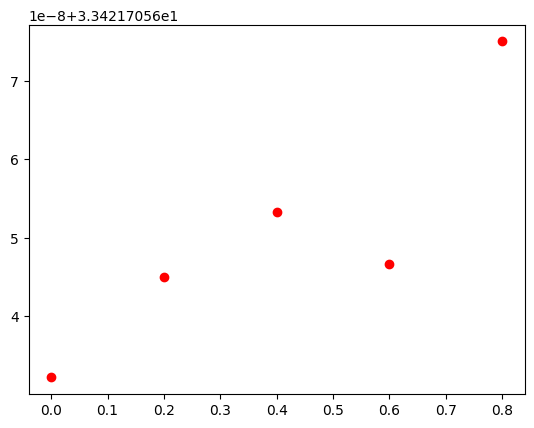

In [197]:
plt.plot( x, input_pos[:, 0] , 'ro', label='Pontos conhecidos')

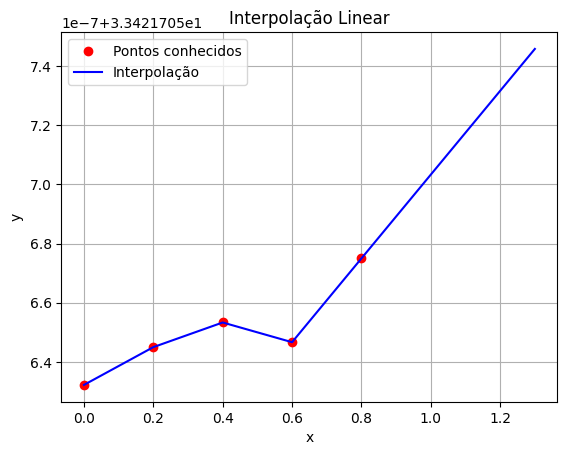

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Definindo os pontos conhecidos
x_known = x
y_known = input_pos[:, 0] 

# Definindo o intervalo de x para interpolação
x_interp = np.append(x_known, 1.3)  # Intervalo de 0 a 1.3 para interpolação

# Realizando a interpolação
f_lat_interp =  scipy.interpolate.interp1d(x, y_known, fill_value='extrapolate')


# Calculando os valores interpolados de y
y_interp = f_lat_interp(x_interp)

# Plotando os resultados
plt.plot(x_known, y_known, 'ro', label='Pontos conhecidos')
plt.plot(x_interp, y_interp, 'b-', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolação Linear')
plt.legend()
plt.grid(True)
plt.show()


Para refazer a interpolação linear para \( x = 1.3 \), vamos utilizar os pontos conhecidos:

\[
\begin{align*}
(x_1, y_1) & = (0, 33.42170563) \\
(x_2, y_2) & = (0.2, 33.42170565) \\
(x_3, y_3) & = (0.4, 33.42170565) \\
(x_4, y_4) & = (0.6, 33.42170565) \\
(x_5, y_5) & = (0.8, 33.42170567)
\end{align*}
\]

Para \(x = 1.3\), vamos realizar a interpolação linear utilizando os pontos conhecidos:

1. Os pontos conhecidos mais próximos a \(x = 1.3\) são \((0.8, 33.42170567)\) e \((0.6, 33.42170566)\).

2. Calculamos a inclinação da reta que une esses dois pontos:

$$m = \frac{{y_2 - y_1}}{{x_2 - x_1}} = \frac{{33.42170567 - 33.42170565}}{{0.8 - 0.6}} = \frac{{2\cdot 10^{-8}}}{{0.2}} =1 \cdot 10^{-7} $$


3. Usamos a equação da reta para encontrar o valor de \(y\) correspondente a \(x = 1.3\):

$$y = y_1 + m \cdot (x - x_1) = 33.42170565 + 1 \cdot 10^{-7}  \cdot (1.3 - 0.6) = 33.42170575 $$
Portanto, o valor interpolado de \(y\) para \(x = 1.3\) é aproximadamente \(33.42170575\).

In [195]:
input_pos[:, 0] , x

(array([33.42170563, 33.42170565, 33.42170565, 33.42170565, 33.42170567]),
 array([0. , 0.2, 0.4, 0.6, 0.8]))

#### %% Step 1: Estimate positions in the new timestamp (linear interpolation)


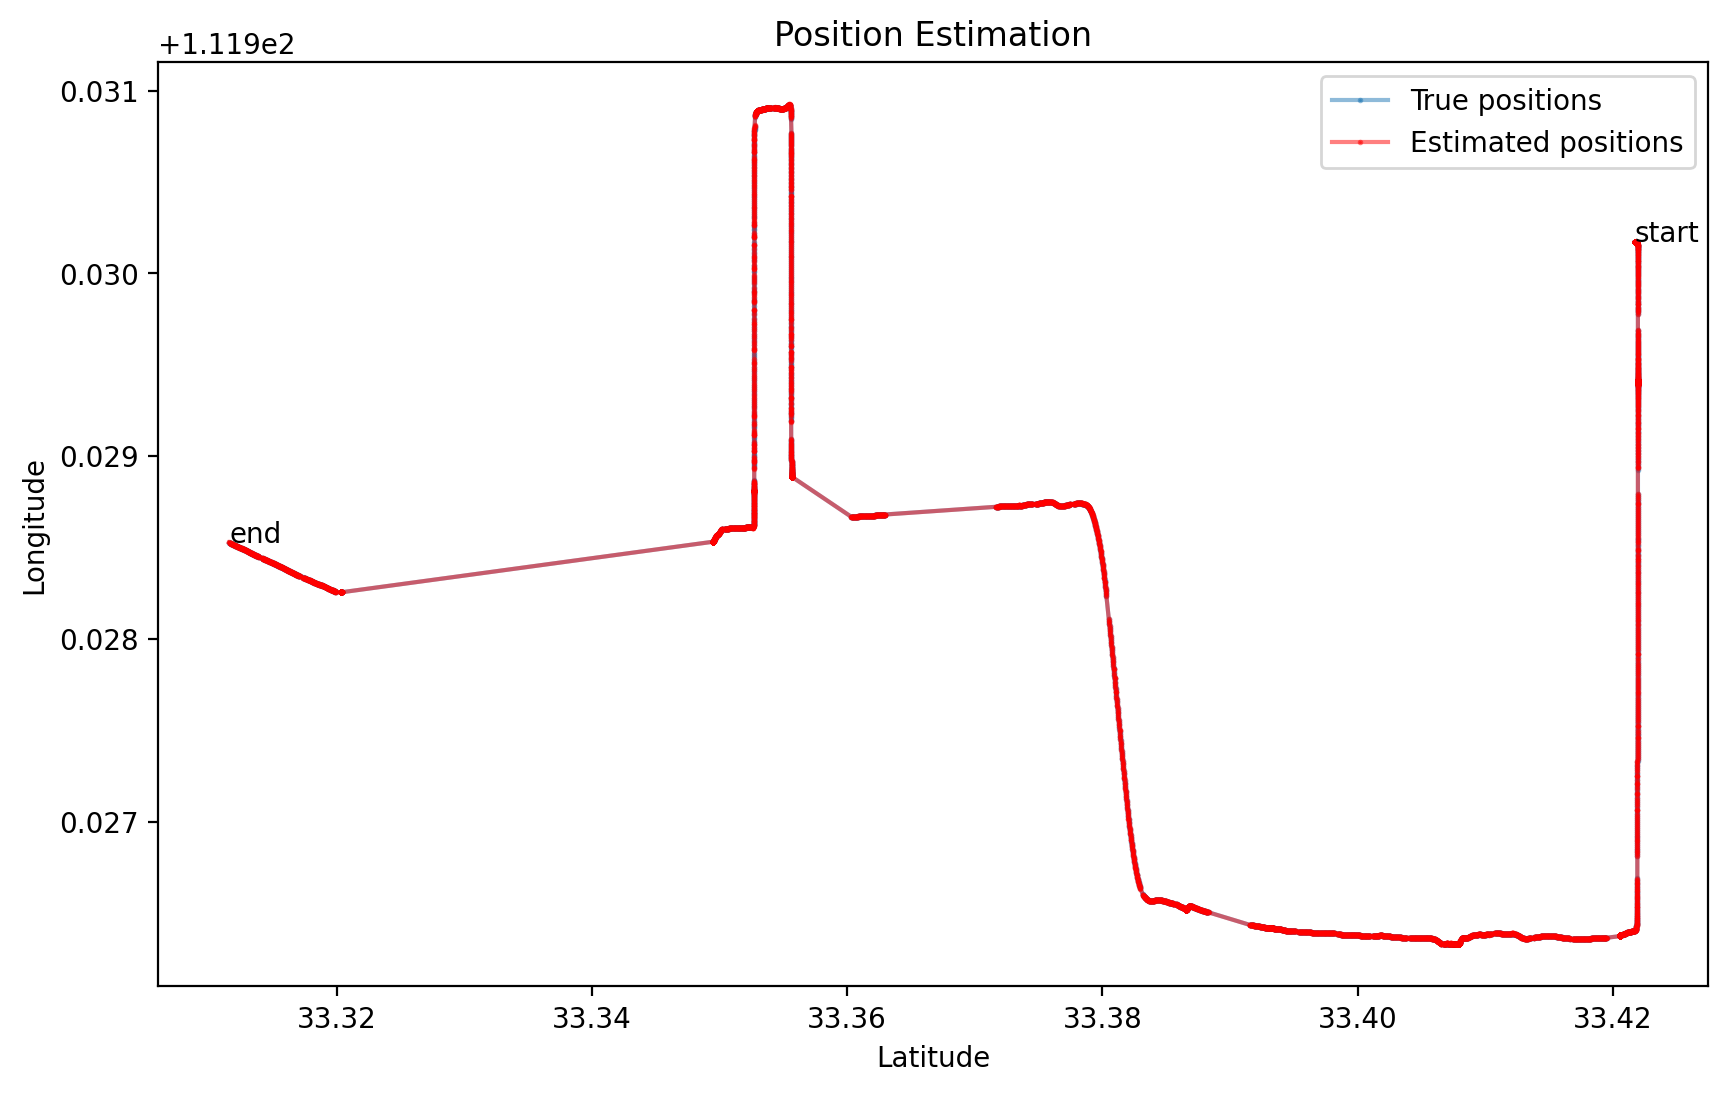

In [199]:
if True:
    plt.figure(figsize=(10, 6), dpi=200)
    n = np.arange(8000)
    plt.plot(y_pos1[n, 0], -y_pos1[n, 1], alpha=.5,
             label='True positions', marker='o', markersize=1)
    plt.plot(gps1_est_pos[n, 0], -gps1_est_pos[n, 1], alpha=.5, 
             label='Estimated positions', c='r', marker='o', markersize=1)
    plt.annotate('start', xy=(y_pos1[0,0], -y_pos1[0,1]))
    plt.annotate('end', xy=(y_pos1[n[-1],0], -y_pos1[n[-1],1]))
    plt.title('Position Estimation')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()
    plt.show()

In [212]:
gps1_est_pos[:,0] , train_positions[:, -1, 0, 0]

(array([33.42170575, 33.42170569, 33.42170566, ..., 33.37800926,
        33.37801588, 33.37801599]),
 array([33.42170567, 33.42170567, 33.42170567, ..., 33.37797421,
        33.37798113, 33.37798615]))

### 2.1 - Determine a direção dos veículos usando a última localização disponível e a nova localização estimada

In [205]:
lat_deltas = gps1_est_pos[:, 0] - train_positions[:, -1, 0, 0]
lon_deltas = gps1_est_pos[:, 1] - train_positions[:, -1, 0, 1]

# Compute the orientation (heading) based on the position deltas
heading = compute_ori_from_pos_delta(lat_deltas, lon_deltas)

# 2.2 - Determine relative position (converted to orientation) between vehicles
# Calculate the difference in latitude and longitude between the estimated GPS positions of vehicle 1 and vehicle 2
lat_deltas = gps1_est_pos[:, 0] - gps2_est_pos[:, 0]
lon_deltas = gps1_est_pos[:, 1] - gps2_est_pos[:, 1]

# Compute the orientation (relative position) based on the position deltas
ori_rel = compute_ori_from_pos_delta(lat_deltas, lon_deltas)

# Compute the estimated Angle of Arrival (AOA) using the relative orientation, heading, and a reference angle
# The relative orientation is subtracted from the heading and a constant angle (pi/4) is subtracted from the result
aoa_estimation = norm_2pi(-1 * (ori_rel - heading - np.pi / 4))

# Check if the estimated AOA correlates enough for an accurate prediction

In [214]:
heading.shape

(23187,)



Seja \($ n_{\text{samples}}$ \) o número de amostras:

$$
n_{\text{samples}} = \text{len}(\text{lat\_deltas})$$

Então, criamos um vetor de zeros para armazenar as orientações calculadas:

$$
\text{pose} = \text{np.zeros}(n_{\text{samples}})$$

Essa representação matemática descreve o número de amostras e a criação do vetor de orientações.

Para cada posição \( i \) em \( $\text{lat\_deltas}$ \) e \( $\text{lon\_deltas}$ \):


$$\text{delta\_lat} = \text{lat\_deltas}[i-1]$$
$$\text{delta\_lon} = \text{lon\_deltas}[i-1]$$


Se $\text{delta\_lon} = 0 $, então:

$$\text{Se \text{delta\_lat}} = 0 , então $$ 


$$\hspace{2em} \text{pose}[i] = 0$$

$$\text{Senão, se } \text{delta\_lat} > 0 \text{, então}$$


$$\hspace{2em} \text{slope} = \frac{\pi}{2} $$

$$\text{Senão, se } \text{delta\_lat} < 0 \text{, então}$$

$$\hspace{2em} \text{slope} = -\frac{\pi}{2}$$


Senão:

$$\text{slope} = \arctan{\left( \frac{\text{delta\_lat}}{\text{delta\_lon}} \right)}$$

$$\text{Se } \text{delta\_lat} = 0 \text{, então}$$

$$\hspace{2em} \text{slope} = \pi \text{ se } \text{delta\_lon} < 0 \text{, senão } 0$$

$$\text{Senão, se } \text{delta\_lat} < 0 \text{ e } \text{delta\_lon} < 0 \text{, então}$$


$$\hspace{2em} \text{slope} = -\pi + \text{slope}$$

$$\text{Senão, se } \text{delta\_lon} < 0 \text{ e } \text{delta\_lat} > 0 \text{, então}$$

$$\hspace{2em} \text{slope} = \pi + \text{slope}$$


Finalmente:

$\text{pose}[i] = \text{slope}$



In [216]:
x

array([    0,     1,     2, ..., 23184, 23185, 23186])

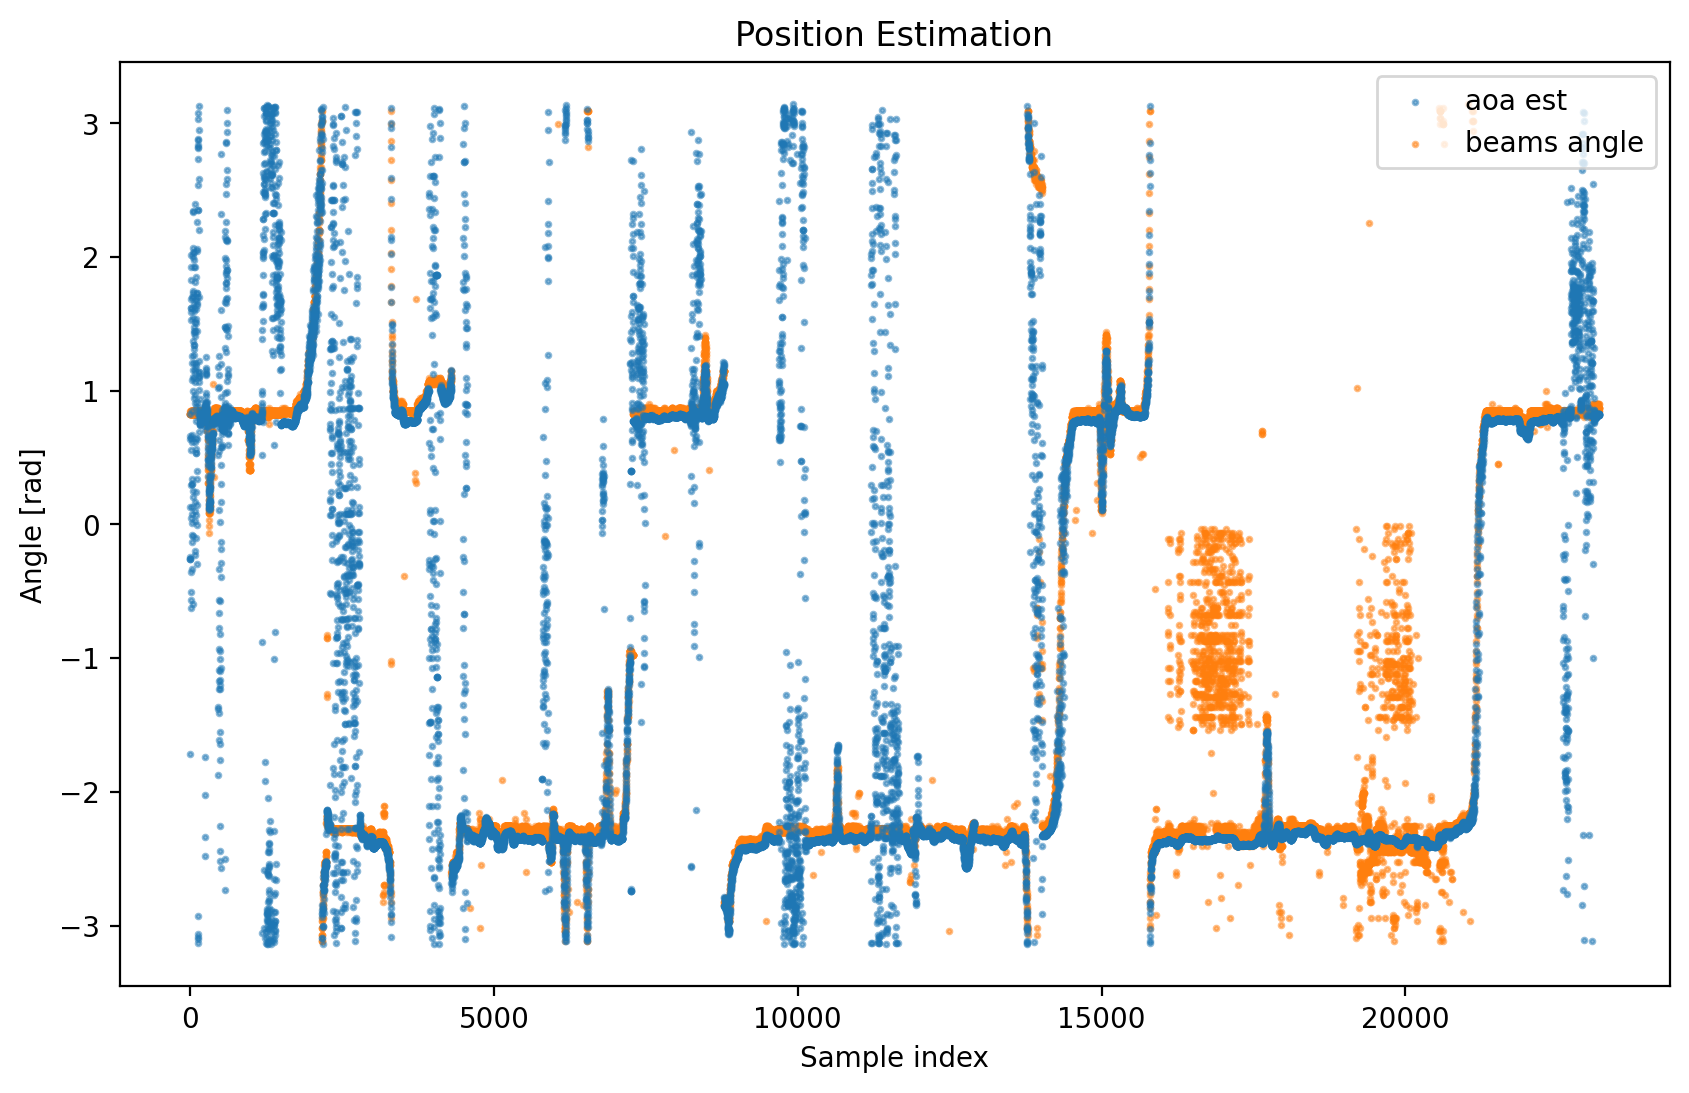

In [206]:

if True:
    beams_angle = y_true_beams/*2*255np.pi - np.pi
    x = np.arange(len(aoa_estimation))
    plt.figure(figsize=(10, 6), dpi=200)
    plt.scatter(x, aoa_estimation, alpha=.5, s=3, zorder=2, label='aoa est')
    plt.scatter(x, beams_angle, alpha=.5, s=3, label='beams angle')
    plt.title('Position Estimation')
    plt.xlabel('Sample index')
    plt.ylabel('Angle [rad]')
    plt.legend()
    plt.show()